# How much are top merchants spending per order? Are we retaining these top buyers?

To accomplish in this notebook- 
- Define "Top buyer" - They come every month? They have spent the most money? They spend a certain amount every month?
- Recommend definition of "top buyers" 

In [137]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
baskets = pd.read_csv('baskets_sample_random_10.csv')
baskets['datetime'] = baskets['placed_at'].apply(lambda x: datetime.fromisoformat(x))

#pandas.Series.dt is an interface on a pandas series that gives you convenient access to operations on data stored as a pandas datetime. 
baskets['date'] = baskets['datetime'].dt.date
baskets['year'] = baskets['datetime'].dt.year
baskets['month'] = baskets['datetime'].dt.month
baskets['day'] = baskets['datetime'].dt.day
baskets['hour'] = baskets['datetime'].dt.hour
baskets['weekday'] = baskets['datetime'].dt.weekday

#### Start by finding top buyers in terms of total amount spent.

In [138]:
baskets['spent'] = baskets['price'] * baskets['qty']

In [139]:
baskets.describe()

,id,order_id,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,year,month,day,hour,weekday,spent
count,29305.000000,29305.000000,29305.000000,29305.000000,29298.000000,29298.000000,2.930500e+04,2.930500e+04,29305.000000,29305.000000,29305.000000,29305.000000,29305.000000,2.930500e+04
mean,162948.006825,27337.267838,1061.053574,977.588671,10.860946,50.808485,6.921692e+03,1.379133e+05,2021.487903,6.817608,16.348405,12.932196,2.666303,5.621916e+05
std,95745.525000,18450.495064,761.056051,348.157681,8.353926,31.280838,1.168396e+06,1.355361e+05,0.499862,4.009774,8.976516,3.931298,1.795167,2.343982e+06
min,126.000000,23.000000,10.000000,5.000000,1.000000,1.000000,1.000000e+00,0.000000e+00,2021.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00
25%,80106.000000,10296.000000,352.000000,755.000000,4.000000,30.000000,1.000000e+00,4.550000e+04,2021.000000,3.000000,8.000000,10.000000,1.000000,1.230000e+05
50%,158748.000000,25824.000000,934.000000,875.000000,9.000000,48.000000,2.000000e+00,1.070000e+05,2021.000000,7.000000,17.000000,13.000000,3.000000,2.230000e+05
75%,242651.000000,43776.000000,1717.000000,1055.000000,15.000000,79.000000,5.000000e+00,1.845000e+05,2022.000000,11.000000,24.000000,15.000000,4.000000,4.860000e+05
max,338874.000000,61439.000000,3160.000000,2383.000000,35.000000,108.000000,2.000000e+08,2.175000e+06,2022.000000,12.000000,31.000000,23.000000,6.000000,2.775000e+08


Remove first 5 months of data from dataframe.

In [140]:
baskets.date.min()
baskets.date.max()

datetime.date(2022, 7, 31)

In [141]:
baskets = baskets[baskets['date'] > pd.to_datetime('2021-7-31').date()]

In [142]:
baskets.date.min()
baskets.date.max()

datetime.date(2022, 7, 31)

Find total amount spent by each merchant and sort highest to lowest.

In [143]:
baskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
488     1.405221e+09
352     1.306918e+09
664     4.993791e+08
934     4.501614e+08
1497    3.997520e+08
            ...     
1811    1.100000e+05
1402    1.080000e+05
1608    8.000000e+04
1853    7.500000e+04
1806    6.760000e+04
Name: spent, Length: 316, dtype: float64

Notice that the top 5 most spending merchants are 488,352,134,664,168. Lets plot their spending over time to see if they are consistent spenders.

In [144]:
baskets['month_order'] = baskets['year']*12 + baskets['month']

Created month_order to reindex data to start at end of july

Created options to parse through top 5 spenders

In [145]:
options = [488,352,664,934,1497]

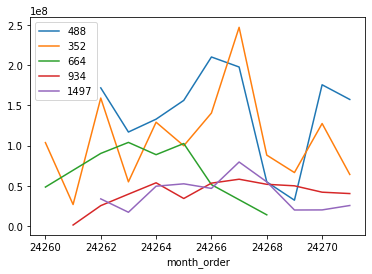

In [146]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([488,352,664,934,1497],fancybox = True)


Notice that 488 and 352 seem to follow dip in spring-summer (Ramadon?)
352 is inconsistent while 934 is very consistent.
664 seems to not have ordered in a while. Lets see.

In [147]:
baskets[baskets['merchant_id'] == 664].date.max()

datetime.date(2022, 4, 29)

This buyer has not made a purchase since April 2022, though we have data until July. Why is this?

More questions: 
- What sku's are 488 & 352 buying that makes them less likely to buy during Ramadon?
- Who spent the most in just the last month?
- Who spent the most in the last 6 months?

## Let's compare spending in the last 6 months. Will the same buyers be in the list?

In [151]:
sixbaskets = baskets[baskets['month_order'] > 24265]

In [152]:
sixbaskets.head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
18361,199371,33900,2022-02-01 04:59:15.772,1970,812,9.0,48.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
18362,199372,33900,2022-02-01 04:59:15.772,1970,814,9.0,48.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
18363,199373,33900,2022-02-01 04:59:15.772,1970,817,9.0,48.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,24266
18364,199462,33307,2022-02-01 11:33:33.134,600,1622,4.0,57.0,5,160000.0,2022-02-01 11:33:33.134,2022-02-01,2022,2,1,11,1,800000.0,24266
18365,199463,33307,2022-02-01 11:33:33.134,600,1741,4.0,57.0,5,161000.0,2022-02-01 11:33:33.134,2022-02-01,2022,2,1,11,1,805000.0,24266


In [153]:
sixbaskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
488     827635175.0
352     733581500.0
934     295872000.0
1497    246809000.0
1951    201736948.0
           ...     
1648       200000.0
2735       193600.0
3043       188400.0
2947       154476.0
46         120000.0
Name: spent, Length: 212, dtype: float64

Top spenders are merchant_id's 488,352,934,1497,1951

In [154]:
options = [488,352,934,1497,1951]

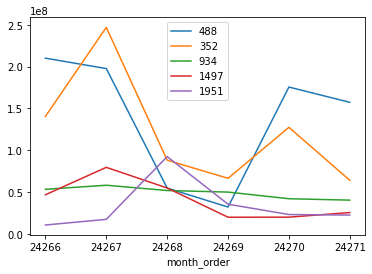

In [158]:
for i in range(5):
    sixbaskets[sixbaskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([488,352,934,1497,1951],fancybox = True)


It looks like merchant 1951 has increased spending quite a bit in the last 6 months. Let's track their spending over the year. 

In [163]:
baskets[baskets['merchant_id']==1951].date.min()

datetime.date(2021, 11, 16)

Their first order was in november of 2021, so if they are a high spender now it makes sense that their average would not be high enough to make the top five for the whole year. 

month
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
Name: spent, dtype: object

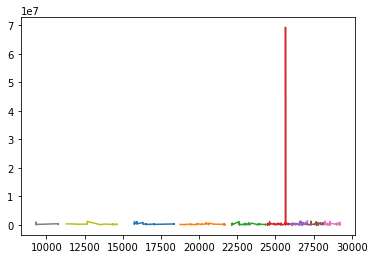

In [165]:
baskets[baskets['merchant_id']==1951].groupby('month')['spent'].plot()

In [166]:
baskets[baskets['merchant_id']==1951].head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
9305,102074,14286,2021-11-16 12:42:11.757,1951,875,3.0,80.0,1,187000.0,2021-11-16 12:42:11.757,2021-11-16,2021,11,16,12,1,187000.0,24263
9306,102075,14286,2021-11-16 12:42:11.757,1951,857,4.0,57.0,1,205000.0,2021-11-16 12:42:11.757,2021-11-16,2021,11,16,12,1,205000.0,24263
9307,102076,14286,2021-11-16 12:42:11.757,1951,856,4.0,57.0,5,206000.0,2021-11-16 12:42:11.757,2021-11-16,2021,11,16,12,1,1030000.0,24263
9308,102077,14286,2021-11-16 12:42:11.757,1951,625,19.0,77.0,3,61000.0,2021-11-16 12:42:11.757,2021-11-16,2021,11,16,12,1,183000.0,24263
10781,120432,18020,2021-11-29 07:19:01.107,1951,615,1.0,13.0,10,44500.0,2021-11-29 07:19:01.107,2021-11-29,2021,11,29,7,0,445000.0,24263


In [167]:
baskets[baskets['merchant_id']==1951].spent.max()

69375000.0

In [168]:
baskets.spent.max()

78000000.0

In [170]:
baskets.spent.mean()

530322.510988237

In [171]:
baskets[baskets['merchant_id']==1951].spent.mean()

410537.4037037037

Comparing 1951's usual behavior and the behavior of the data as a whole, they made an unsually large order this past six months, which put them in the top 5 buyers. The order was placed on April 26, and was for item # 734, which is a very expensive item that they bought 50 of. This is right in the middle of ramadon, I wonder which category it was in? The sub_cat is 30.0, and the top_cat_id is 12.0. This is very notable and shows that this is not a consistent top buyer. 1951 made a one time purchase, but since they are not in the top buying group for consistency, they are not relevant to the company's desire to retain loyal customers. 

In [174]:
baskets[baskets['spent']==69375000.0].head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
25655,290023,51842,2022-04-26 18:40:12.451,1951,734,12.0,30.0,50,1387500.0,2022-04-26 18:40:12.451,2022-04-26,2022,4,26,18,1,69375000.0,24268
